
In this notebook, we will implement the attention mechanism from scratch. Specifically, we will explore four different variants of attention mechanisms:

1. **Simplified Self-Attention**:  
   A basic self-attention technique to introduce the broader concept of attention mechanisms.

2. **Self-Attention with Trainable Weights**:  
   A more advanced version of self-attention that includes trainable weights, forming the foundation of the mechanism used in large language models (LLMs).

3. **Causal Self-Attention**:  
   A variant of self-attention used in LLMs, allowing the model to consider only previous and current inputs in a sequence, thus ensuring temporal order during text generation.

4. **Multi-Head Attention**:  
   An extension of self-attention and causal attention, enabling the model to attend to information simultaneously from different representation subspaces.


## A simple self-attention mechanism without trainable weights
et’s begin by implementing a simplified variant of self-attention, free from any trainable weights

In [1]:
# lET's assume we've already tokenize and calculate the embedding vector of our input sequence : 
# input sequence : Your journey starts with one step 

import torch 

inputs = torch.tensor(
    [[0.43, 0.15, 0.89], # Your (x^1)
 [0.55, 0.87, 0.66], # journey (x^2)
 [0.57, 0.85, 0.64], # starts (x^3)
 [0.22, 0.58, 0.33], # with (x^4)
 [0.77, 0.25, 0.10], # one (x^5)
 [0.05, 0.80, 0.55]] # step (x^6
)

In [2]:
# let use they word journey as the query : 

query = inputs[1] #x2

# now let's calculate attention scores between our input query and all other word in the input sequence 

att_scores_2 = torch.empty(inputs.shape[0]) # initialise an empty tensor 

for i, x_i in enumerate(inputs):
    att_scores_2[i] = torch.dot(x_i, query)

print(att_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


Now we've obtained the attention score between our query (journey = x_2 = [0.55, 0.87, 0.66]) and all the words in our embedding matrix. We can notice that 1.4950 is the highest score because it's the attention score between x_2 and itself.

Now, let's normalize the attention scores, which means adjusting all the values to be between 0 and 1 so that we obtain a probabilistic distribution.

In [3]:
sum_score = att_scores_2.sum()

att_scores_2_normalized = att_scores_2/sum_score

print(att_scores_2_normalized)

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])


In [4]:
# Normalizing by using softmax function

def softmax_naive(x):
    return torch.exp(x)/torch.exp(x).sum(dim=0)

In [5]:
att_score_normalized = softmax_naive(att_scores_2)
print("attention score normalized : ", att_score_normalized )
print("Sum attention score normalized: ", att_score_normalized.sum())

attention score normalized :  tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum attention score normalized:  tensor(1.)


In [6]:
att_score_normalized = torch.softmax(att_scores_2, dim=0)
print("Attention weights:", att_score_normalized)
print("Sum:", att_score_normalized.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


After computing the normalized attention weights, we calculate the context vector \( z_2 \) by multiplying each input token vector \( x(i) \) by its corresponding attention weight and summing the resulting weighted vectors.

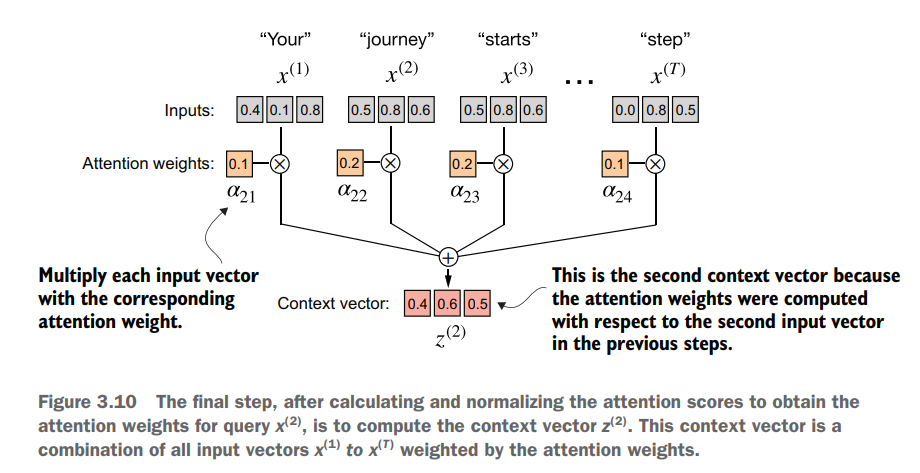

In [7]:
query = inputs[1]

context_vec_2 = torch.zeros(query.shape)
for i, x_i in enumerate(inputs):
    context_vec_2 += att_score_normalized[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


##  Computing attention weights for all input tokens

So far, we've calculated context_vec_2 for just one word in our input embedding, now let's generalize this process to all 
our embedding matrix 

In [8]:
inputs

tensor([[0.4300, 0.1500, 0.8900],
        [0.5500, 0.8700, 0.6600],
        [0.5700, 0.8500, 0.6400],
        [0.2200, 0.5800, 0.3300],
        [0.7700, 0.2500, 0.1000],
        [0.0500, 0.8000, 0.5500]])

In [9]:
att_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, x_j in enumerate(inputs):
        att_scores[i, j] = torch.dot(x_i, x_j)

print(att_scores)
print("\n Normalized attention score: \n ", torch.softmax(att_scores, dim=-1))

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

 Normalized attention score: 
  tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [10]:
# we can comput the same by using 

att_scores = inputs@inputs.T
print(att_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [11]:
att_scores_normalized = torch.softmax(att_scores, dim=-1)

print(att_scores_normalized)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In the third and final step, we use these attention weights to compute all
context vectors via matrix multiplication:

In [12]:
context_vector = att_scores_normalized@inputs

print(context_vector)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


In [13]:
# let's summarize all the steps in this function

def simple_self_attention(input_embeddings):
    att_scores = input_embeddings@input_embeddings.T
    normalized_att_scores = torch.softmax(att_scores, dim=1)
    context_vector = normalized_att_scores@inputs
    return context_vector

In [14]:
simple_self_attention(inputs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

## Implementing self-attention with trainable weights

 Previously, we coded a simplified attention mechanism to understand the basic mechanism behind 
attention mechanisms. Now, we add trainable weights to this attention mechanism. Later, we will extend this 
self-attention mechanism by adding a causal mask and multiple heads.

The most notable difference between our simplified self attention mechanism and the one we're gonna do here,  is the introduction of weight matrices that are
updated during model training




In [15]:
# let's start by using just one word in our embedding matrix, the word journey = x_2 = inputs[1]

x_2 = inputs[1] # the word journey, the second embedding vector

d_in = inputs.shape[1]  # input dimension, here we have d_in = 3 

d_out = 2  # output dimension that we want 



In [16]:
# Now let's initialize the weights matrices Wq, Wk, Wv | query, keys, values

torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

# We set requires_grad=False to reduce clutter in the outputs, but if we were to use
# the weight matrices for model training, we would set requires_grad=True to update
# these matrices during model training.

In [17]:
W_query

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])

In [18]:
# Now, let's compute 

query_2 = x_2@W_query 
key_2 = x_2@W_key
value_2 = x_2@W_value

print(query_2)

# The output for the query results in a two-dimensional vector since we set the number
# of columns of the corresponding weight matrix, via d_out, to 2

tensor([0.4306, 1.4551])


In [19]:
keys = inputs @ W_key 
values = inputs @ W_value
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


In [20]:
# First let compute the attention score for the query 2 : x_2

keys_2 = keys[1] 
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


In [21]:
att_scores_2 = query_2@keys.T

In [22]:
att_scores_2

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

In [23]:
# normalization

d_k = keys.shape[-1]
att_score_normalized = torch.softmax(att_scores_2/d_k**0.5, dim=-1)

In [24]:
print(att_score_normalized )

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


The rationale behind scaled-dot product attention
The reason for the normalization by the embedding dimension size is to improve the
training performance by avoiding small gradients. For instance, when scaling up the
embedding dimension, which is typically greater than 1,000 for GPT-like LLMs, large
dot products can result in very small gradients during backpropagation due to the
softmax function applied to them. As dot products increase, the softmax function
behaves more like a step function, resulting in gradients nearing zero. These small
gradients can drastically slow down learning or cause training to stagnate.
The scaling by the square root of the embedding dimension is the reason why this
self-attention mechanism is also called scaled-dot product attention. 

In [25]:
# Now, the final step is to compute the context vectors

context_vec_2 = att_score_normalized @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


In [26]:
import torch
import torch.nn as nn

class SelfAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_key = torch.nn.Parameter(torch.rand(d_in, d_out))
        self.W_value = torch.nn.Parameter(torch.rand(d_in, d_out))
        
    def forward(self, x):
        query = x @ self.W_query
        keys = x @ self.W_key  
        values = x @ self.W_value
        
        d_k = keys.shape[-1]
        
        att_scores = query @ keys.T
        
        att_score_normalized = torch.softmax(att_scores / d_k**0.5, dim=-1)  
        
        context_vec = att_score_normalized @ values
        
        return context_vec


In [27]:
# let apply this to our input embedding
torch.manual_seed(123)

self_attention = SelfAttention(d_in, d_out)

print(self_attention.forward(inputs))

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)


 We can improve the SelfAttention_v1 implementation further by utilizing
PyTorch’s nn.Linear layers, which effectively perform matrix multiplication when
the bias units are disabled. Additionally, a significant advantage of using nn.Linear
instead of manually implementing nn.Parameter(torch.rand(...)) is that nn.Linear
has an optimized weight initialization scheme, contributing to more stable and
effective model training

In [28]:
class SelfAttentionV2:
    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias = qkv_bias)
        
    def forward(self, x):
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        d_k = keys.shape[-1]
        
        att_scores = queries @ keys.T
        
        att_scores_normalized = torch.softmax(att_scores/d_k**0.5, dim=-1)
        
        context_vec = att_scores_normalized @ values
        
        return context_vec


In [29]:
attention = SelfAttentionV2(3, 2)
attention.forward(x=inputs)

tensor([[0.5085, 0.3508],
        [0.5084, 0.3508],
        [0.5084, 0.3506],
        [0.5074, 0.3471],
        [0.5076, 0.3446],
        [0.5077, 0.3493]], grad_fn=<MmBackward0>)

Next, we will improve the self-attention mechanism by adding causal attention, which restricts the model from accessing future information in the sequence, and multi-head attention, which allows the model to focus on different data representations simultaneously.

## Hiding Future Words with Causal Attention

Causal attention, also called masked attention, ensures that the self-attention mechanism only considers previous and current tokens in a sequence when predicting the next token. This is important for many LLM tasks, unlike standard self-attention, which has access to the entire input sequence at once.


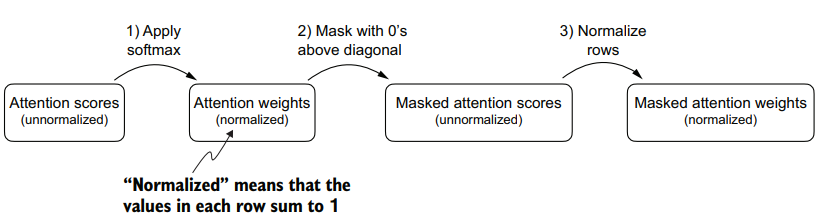

In [30]:
# creating attention mask matrix

context_length = att_scores.shape[0]

simple_mask = torch.tril(torch.ones(context_length, context_length))

print(simple_mask)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


We've implemented the mask using PyTorch’s tril function to create a mask
where the values above the diagonal are zero

In [31]:
# The we multiplie the mask with attention scores to get masked attention scores

masked_attention = att_scores_normalized*simple_mask

print(masked_attention)

tensor([[0.2098, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1385, 0.2379, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1390, 0.2369, 0.2326, 0.0000, 0.0000, 0.0000],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.0000, 0.0000],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.0000],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [32]:
# Normalizing the masked attention weight

row_sum = masked_attention.sum(dim=1, keepdim=True)
masked_attention_norm = masked_attention/row_sum

print(masked_attention_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3680, 0.6320, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2284, 0.3893, 0.3822, 0.0000, 0.0000, 0.0000],
        [0.2046, 0.2956, 0.2915, 0.2084, 0.0000, 0.0000],
        [0.1753, 0.2250, 0.2269, 0.1570, 0.2158, 0.0000],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


While we could wrap up our implementation of causal attention at this point, we can
still improve it. Let’s take a mathematical property of the softmax function and implement the computation of the masked attention weights more efficiently in fewer step

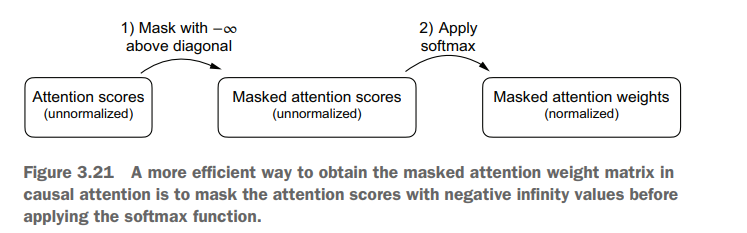

he softmax function converts its inputs into a probability distribution. When negative infinity values (-∞) are present in a row, the softmax function treats them as zero
probability. (Mathematically, this is because e –∞ approaches 0.)
We can implement this more efficient masking “trick” by creating a mask with 1s
above the diagonal and then replacing these 1s with negative infinity (-inf) values


In [33]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
print(mask)

tensor([[0., 1., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0.]])


In [34]:
masked_att = att_scores.masked_fill(mask.bool(), -torch.inf)

In [35]:
masked_att

tensor([[0.9995,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.9544, 1.4950,   -inf,   -inf,   -inf,   -inf],
        [0.9422, 1.4754, 1.4570,   -inf,   -inf,   -inf],
        [0.4753, 0.8434, 0.8296, 0.4937,   -inf,   -inf],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654,   -inf],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

In [36]:
att_scores_normalized = torch.softmax(masked_att/ keys.shape[-1]**0.5, dim=1)

print(att_scores_normalized)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4056, 0.5944, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2566, 0.3741, 0.3693, 0.0000, 0.0000, 0.0000],
        [0.2176, 0.2823, 0.2796, 0.2205, 0.0000, 0.0000],
        [0.1826, 0.2178, 0.2191, 0.1689, 0.2115, 0.0000],
        [0.1473, 0.2033, 0.1996, 0.1500, 0.1160, 0.1839]])


## Masking Additional Attention Weights with Dropout

Dropout in deep learning is a technique where randomly selected hidden layer units are ignored during training to prevent overfitting. This ensures the model doesn't become overly reliant on specific units. Importantly, dropout is only used during training and is disabled afterward.

In transformer architectures like GPT, dropout in the attention mechanism is typically applied in two places: after calculating the attention weights or after applying them to the value vectors. In this example, we apply dropout after computing the attention weights.

The following code example uses a 50% dropout rate, meaning half of the attention weights are masked. (For training the GPT model later, we will use a lower dropout rate such as 0.1 or 0.2.) We start by applying PyTorch's dropout implementation to a simple 6 × 6 tensor filled with 1s.


In [37]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) 
example = torch.ones(6, 6) 
print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


The dropout mask
applied to the
attention scores will
zero out certain
attention scores

When applying dropout to an attention weight matrix with a rate of 50%, half of the
elements in the matrix are randomly set to zero. To compensate for the reduction in
active elements, the values of the remaining elements in the matrix are scaled up by a
factor of 1/0.5 = 2. This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains
consistent during both the training and inference phases



In [38]:
torch.manual_seed(123)
dropout(att_scores_normalized)

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.1888, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7386, 0.0000, 0.0000, 0.0000],
        [0.4352, 0.5646, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3652, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4065, 0.0000, 0.0000, 0.0000, 0.0000]])

### Implementing a compact causal attention class

In [39]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, qkv_bias=False):
        super().__init__()

        self.d_out = d_out
        
        # Define linear transformations for query, key, and value matrices with optional bias
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        self.dropout = nn.Dropout(dropout)
        
        # Create a causal mask using the upper triangular matrix. This ensures that the model
        # only attends to previous tokens in the sequence (no access to future tokens).
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        
        # Compute the key, query, and value matrices by applying the corresponding linear transformations
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        
        # Compute the attention scores by performing a dot product between queries and the transposed keys
        # We transpose dimensions 1 and 2, keeping the batch dimension (0) intact
        att_scores = queries @ keys.transpose(1, 2)
        
        # Apply the causal mask to prevent the model from attending to future tokens
        # Replace masked positions with negative infinity (-inf)
        att_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        
        # Apply softmax to get attention weights, scaling by the square root of the key dimension
        att_weights = torch.softmax(att_scores / keys.shape[-1]**0.5, dim=-1)
        
        # Apply dropout to the attention weights for regularization
        att_weights = self.dropout(att_weights)
        
        context_vec = att_weights @ values
        
        return context_vec


In [40]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


In [41]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)

context_vecs.shape: torch.Size([2, 6, 2])


## Extending single-head attention to multi-head attention

The final step involves expanding the causal attention class to multi-head attention, where multiple heads operate independently. First, multiple CausalAttention modules will be stacked to intuitively build the multi-head attention module. Then, a more computationally efficient implementation of the multi-head attention module will be created.

 ### Stacking multiple single-head attention layers
In practical terms, implementing multi-head attention involves creating multiple
instances of the self-attention mechanism, each with its own weights,
and then combining their outputs. Using multiple instances of the self-attention
mechanism can be computationally intensive, but it’s crucial for the kind of complex
pattern recognition that models like transformer-based LLMs are known for.

The main concept of multi-head attention is to run the attention mechanism multiple times in parallel with different learned linear projections. This is done by multiplying input data (such as query, key, and value vectors) by a weight matrix. In code, this can be achieved by creating a MultiHeadAttentionWrapper class that stacks multiple instances of the previously implemented CausalAttention module.

In [52]:
class MultiHeadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
        [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_heads)]
        )
        
    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)
       

In [53]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2

mha = MultiHeadAttentionWrapper(
 d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


The first dimension of the resulting context_vecs tensor is 2 since we have two input
texts (the input texts are duplicated, which is why the context vectors are exactly the
same for those). The second dimension refers to the 6 tokens in each input. The third
dimension refers to the four-dimensional embedding of each token

In [54]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 1

mha = MultiHeadAttentionWrapper(
 d_in, d_out, context_length, 0.0, num_heads=2
)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]],

        [[-0.5740,  0.2216],
         [-0.7320,  0.0155],
         [-0.7774, -0.0546],
         [-0.6979, -0.0817],
         [-0.6538, -0.0957],
         [-0.6424, -0.1065]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])


## Implementing multi-head attention with weight splits

We created a MultiHeadAttentionWrapper using multiple CausalAttention objects. Instead of keeping two separate classes, we can merge them into a single MultiHeadAttention class for better efficiency. This class will handle splitting input tensors into heads, computing attention, and combining results.

In [117]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        # Ensure that d_out is divisible by the number of attention heads
        assert(d_out % num_heads == 0) 
        
        # Define main parameters
        self.d_out = d_out  # Output dimension
        self.num_heads = num_heads  # Number of attention heads
        self.head_dim = d_out // num_heads  # Dimension of each attention head
        
        # Linear layers to project the input into queries, keys, and values
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        
        # Linear layer to combine the outputs from the different attention heads
        self.out_proj = nn.Linear(d_out, d_out)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)
        
        # Upper triangular mask to prevent attending to future positions
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        # Input dimensions: b = batch size, num_tokens = number of tokens, d_in = input dimension
        b, num_tokens, d_in = x.shape
        print(f"Input shape: {x.shape}")
        
        # Project the input to obtain keys, queries, and values
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        print(f"Keys shape after linear projection: {keys.shape}")
        print(f"Queries shape after linear projection: {queries.shape}")
        print(f"Values shape after linear projection: {values.shape}\n\n")
        
        # Reshape to divide the vectors into multiple attention heads (num_heads)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        print(f"Keys shape after reshaping for heads: {keys.shape}")
        print(f"Values shape after reshaping for heads: {values.shape}")
        print(f"Queries shape after reshaping for heads: {queries.shape}\n\n")
        
        # Transpose to bring the heads dimension forward
        keys = keys.transpose(1, 2)  # b, num_heads, num_tokens, head_dim
        queries = queries.transpose(1, 2)  # b, num_heads, num_tokens, head_dim
        values = values.transpose(1, 2)  # b, num_heads, num_tokens, head_dim
        print(f"Keys shape after transpose: {keys.shape}")
        print(f"Queries shape after transpose: {queries.shape}")
        print(f"Values shape after transpose: {values.shape}\n\n")
        
        # Compute attention scores by performing the matrix product of queries and the transposed keys
        attn_scores = queries @ keys.transpose(2, 3)  # b, num_heads, num_tokens, num_tokens
        print(f"Attention scores shape: {attn_scores.shape}")
        
        # Apply the mask to prevent attending to future positions
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)  # Fill masked positions with -inf
        print(f"Attention scores after masking: {attn_scores.shape}\n\n")
        
        # Compute attention weights by applying softmax to the scores
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        print(f"Attention weights shape: {attn_weights.shape}")
        
        # Apply dropout to regularize the attention weights
        attn_weights = self.dropout(attn_weights)
        print(f"Attention weights after dropout: {attn_weights.shape}\n\n")
        
        # Compute the context vector by weighting the values with the attention weights
        context_vec = (attn_weights @ values).transpose(1, 2)
        print(f"Context vector shape after attention: {context_vec.shape}")
        
        # Concatenate the heads back into a single vector
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        print(f"Context vector shape after concatenating heads: {context_vec.shape}")
        
        # Final projection of the context vectors to the output
        context_vec = self.out_proj(context_vec)
        print(f"Final output shape: {context_vec.shape}\n\n")
        
        return context_vec


In [118]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2

In [119]:
print( batch.shape)

torch.Size([2, 6, 3])


In [120]:
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

In [121]:
mha.W_query

Linear(in_features=3, out_features=2, bias=False)

In [122]:
mha.W_key

Linear(in_features=3, out_features=2, bias=False)

In [123]:
mha.out_proj

Linear(in_features=2, out_features=2, bias=True)

In [124]:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

Input shape: torch.Size([2, 6, 3])
Keys shape after linear projection: torch.Size([2, 6, 2])
Queries shape after linear projection: torch.Size([2, 6, 2])
Values shape after linear projection: torch.Size([2, 6, 2])


Keys shape after reshaping for heads: torch.Size([2, 6, 2, 1])
Values shape after reshaping for heads: torch.Size([2, 6, 2, 1])
Queries shape after reshaping for heads: torch.Size([2, 6, 2, 1])


Keys shape after transpose: torch.Size([2, 2, 6, 1])
Queries shape after transpose: torch.Size([2, 2, 6, 1])
Values shape after transpose: torch.Size([2, 2, 6, 1])


Attention scores shape: torch.Size([2, 2, 6, 6])
Attention scores after masking: torch.Size([2, 2, 6, 6])


Attention weights shape: torch.Size([2, 2, 6, 6])
Attention weights after dropout: torch.Size([2, 2, 6, 6])


Context vector shape after attention: torch.Size([2, 6, 2, 1])
Context vector shape after concatenating heads: torch.Size([2, 6, 2])
Final output shape: torch.Size([2, 6, 2])


tensor([[[0.3190, 0.4858],
